In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2

In [2]:
# Load the images directories
path = "./Desktop/scans"
print(os.listdir(path))

image_paths = list(paths.list_images(path))
print(len(image_paths))

['0', '1']
1541


In [21]:
# 
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (200, 200))

    images.append(image)
    labels.append(label)

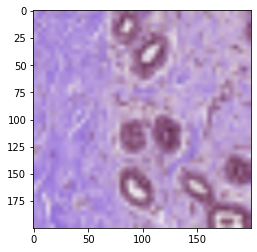

In [22]:
# Plot an image
def plot_image(image):
    plt.imshow(image)

plot_image(images[0])

In [5]:
# Convert into numpy arrays
images = np.array(images) / 255.0
labels = np.array(labels)

In [6]:
# Perform One-hot encoding
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

print(labels[0])

[1. 0.]


In [7]:
#Split dataset
(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, test_size= 0.10, random_state= 42, stratify= labels)

In [8]:
#image data generator
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)

In [9]:
# Build the model
base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input
base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

58900480/58889256 [==============================] - 8s 0us/step


In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
# Compile model
model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')

In [12]:
#keras model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
batch_size = 8
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 5

In [14]:
# Fit the model
history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size= batch_size),
                              steps_per_epoch= train_steps,
                              validation_data = (test_X, test_Y),
                              validation_steps= validation_steps,
                              epochs= epochs)

C:\Users\DEONWI~1\AppData\Local\Temp/ipykernel_32200/3802621659.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size= batch_size),


Epoch 1/10
173/173 [==============================] - 360s 2s/step - loss: 0.3115 - accuracy: 0.9187 - val_loss: 0.2408 - val_accuracy: 0.9226
Epoch 2/10
173/173 [==============================] - 316s 2s/step - loss: 0.2380 - accuracy: 0.9231
Epoch 3/10
173/173 [==============================] - 324s 2s/step - loss: 0.2223 - accuracy: 0.9238
Epoch 4/10
173/173 [==============================] - 314s 2s/step - loss: 0.2085 - accuracy: 0.9245
Epoch 5/10
173/173 [==============================] - 307s 2s/step - loss: 0.2006 - accuracy: 0.9260
Epoch 6/10
173/173 [==============================] - 256s 1s/step - loss: 0.1906 - accuracy: 0.9267
Epoch 7/10
173/173 [==============================] - 267s 2s/step - loss: 0.1877 - accuracy: 0.9282
Epoch 8/10
173/173 [==============================] - 276s 2s/step - loss: 0.1800 - accuracy: 0.9253
Epoch 9/10
173/173 [==============================] - 270s 2s/step - loss: 0.1780 - accuracy: 0.9311
Epoch 10/10
173/173 [============================

In [18]:
# model evaluation
predictions = model.predict(test_X, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)

In [19]:
# classification report/confusion matrix
print(classification_report(actuals, predictions, target_names= label_binarizer.classes_))

cm = confusion_matrix(actuals, predictions)
print(cm)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       143
           1       0.62      0.42      0.50        12

    accuracy                           0.94       155
   macro avg       0.79      0.70      0.73       155
weighted avg       0.93      0.94      0.93       155

[[140   3]
 [  7   5]]


In [20]:
#model accuracy
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.9355
